In [1]:
from causalsim import *
import metrics
from econml.metalearners import XLearner
from econml.dr import DRLearner
from econml.dml import CausalForestDML
from econml.metalearners import TLearner
from econml.metalearners import SLearner
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data Generation 
#### Simple model: Treatment effect for individual i: \tau_i = \beta * x_{i1} 

In [2]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data = simulation_simple(n = n, p = p, beta = beta, sigma = sigma)
print(data.head(10))

         X1       tau  Z   epsilon         Y
0 -0.219095 -0.219095  0  1.400960  1.400960
1  0.184779  0.184779  0 -0.165821 -0.165821
2  0.641464  0.641464  1  0.054721  0.696186
3 -1.596522 -1.596522  1  0.377160 -1.219361
4 -0.876258 -0.876258  0 -0.800859 -0.800859
5 -0.952451 -0.952451  0 -0.676956 -0.676956
6  0.264943  0.264943  1 -1.378242 -1.113299
7  0.172584  0.172584  0  0.847951  0.847951
8 -0.028453 -0.028453  0 -1.097911 -1.097911
9  1.106409  1.106409  1 -0.673568  0.432841


#### Categorical Model

In [3]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data_cat = simulation_categorical(n = n, p = p, beta = beta, sigma = sigma)
print(data_cat.head(10))

         X1  tau  Z   epsilon         Y
0  1.023143    1  1  0.056511  1.056511
1 -0.299046    0  0 -1.296546 -1.296546
2 -0.556704    0  1  0.245307  0.245307
3 -1.052029    0  1  0.940470  0.940470
4 -0.326775    0  0 -0.107064 -0.107064
5 -1.649053    0  1  0.280066  0.280066
6  0.300468    1  0  1.277158  1.277158
7 -0.728725    0  0 -1.486377 -1.486377
8  0.510106    1  0 -0.995065 -0.995065
9 -0.542140    0  0 -0.575164 -0.575164


#### Assigning variables for econml metalearner functions

In [4]:
X = data[[col for col in data.columns if col.startswith('X')]]
T = data['Z'] #treatment indicator
y = data['Y']
tau = np.array(data['tau'])

## Linear Regression

#### y ~ X + Z + X*Z

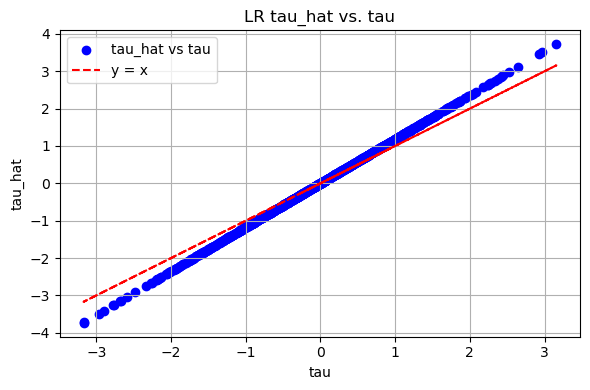

In [5]:
data_lr = data.copy()
data_lr['X1*Z'] = data_lr['X1'] * data_lr['Z'] #Setting interaction term
lr_xfit = data_lr[['X1', 'Z', 'X1*Z']]

lr = LinearRegression() #Fit linear regression
lr.fit(lr_xfit, data_lr['Y'])

bz = lr.coef_[1]
bzx = lr.coef_[2]

tau_hat_lr = bz + bzx*data['X1']


mse_lr, bias_lr, r2_lr = metrics.evaluate(tau, tau_hat_lr)

metrics.tau_plot(tau, tau_hat_lr, 'LR tau_hat vs. tau')

In [6]:
print(tau_hat_lr)

0     -0.255676
1      0.220118
2      0.758128
3     -1.878388
4     -1.029863
         ...   
995    0.196031
996   -0.025514
997   -2.231443
998    1.339006
999    1.117953
Name: X1, Length: 1000, dtype: float64


In [7]:
print(f'LR metrics:\nMse: {mse_lr}\nBias: {bias_lr}\nR2 {r2_lr}')

LR metrics:
Mse: 0.031537708412369775
Bias: 0.005879348993912931
R2 0.9682545065846023


## X-Learner

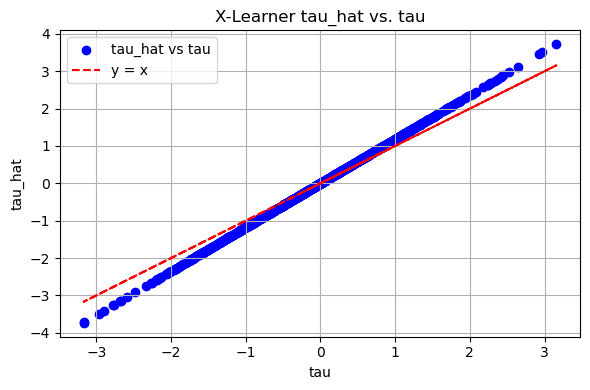

In [8]:
est = XLearner(models=LinearRegression())
est.fit(y, T, X=X)
tau_hat_x = est.effect(X)

mse_x, bias_x, r2_x = metrics.evaluate(tau, tau_hat_x)
metrics.tau_plot(tau, tau_hat_x, 'X-Learner tau_hat vs. tau')

In [9]:
print(f'X-learner metrics:\nMse: {mse_x}\nBias: {bias_x}\nR2 {r2_x}')

X-learner metrics:
Mse: 0.031537708412369726
Bias: 0.005879348993912045
R2 0.9682545065846024


## S + T Learner

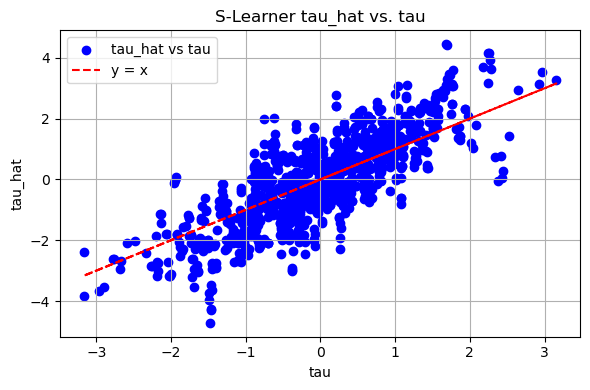

In [10]:
est = SLearner(overall_model=RandomForestRegressor())
est.fit(y, T, X=X)
tau_hat_s = est.effect(X)

mse_s, bias_s, r2_s = metrics.evaluate(tau, tau_hat_s)
metrics.tau_plot(tau, tau_hat_s, 'S-Learner tau_hat vs. tau')

In [11]:
print(f'S-learner metrics:\nMse: {mse_s}\nBias: {bias_s}\nR2 {r2_s}')

S-learner metrics:
Mse: 0.8447692260721135
Bias: 0.019096172507965962
R2 0.14966504372637313


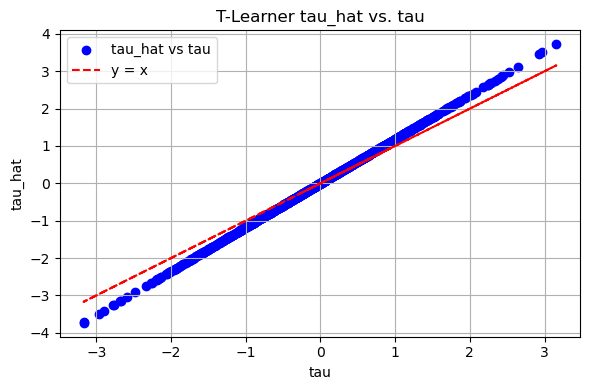

In [12]:
est = TLearner(models=LinearRegression())
est.fit(y, T, X=X)
tau_hat_t = est.effect(X)

mse_t, bias_t, r2_t = metrics.evaluate(tau, tau_hat_t)
metrics.tau_plot(tau, tau_hat_t, 'T-Learner tau_hat vs. tau')

In [13]:
print(f'S-learner metrics:\nMse: {mse_t}\nBias: {bias_t}\nR2 {r2_t}')

S-learner metrics:
Mse: 0.03153770841236979
Bias: 0.005879348993912041
R2 0.9682545065846023


## DR-Learner

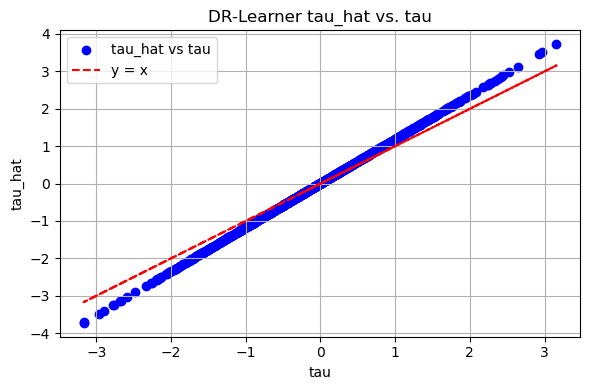

In [14]:
est = DRLearner()
est.fit(y, T, X=X, W=None)
tau_hat_dr = est.effect(X)

mse_dr, bias_dr, r2_dr = metrics.evaluate(tau, tau_hat_dr)
metrics.tau_plot(tau, tau_hat_dr, 'DR-Learner tau_hat vs. tau')

In [15]:
print(f'DR-learner metrics:\nMse: {mse_dr}\nBias: {bias_dr}\nR2 {r2_dr}')

DR-learner metrics:
Mse: 0.031095390460931027
Bias: -0.0013872621611529976
R2 0.9686997387311905


## Causal Forest

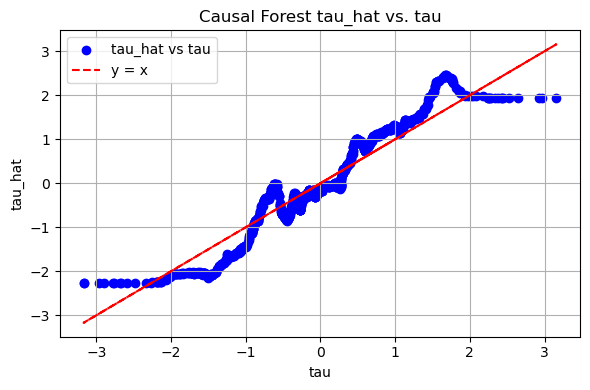

In [16]:
est = CausalForestDML(discrete_treatment=True)
est.fit(y, T, X=X, W=None)
tau_hat_cf = est.effect(X)

mse_cf, bias_cf, r2_cf = metrics.evaluate(tau, tau_hat_cf)
metrics.tau_plot(tau, tau_hat_cf, 'Causal Forest tau_hat vs. tau')

In [17]:
print(f'Causal Forest metrics:\nMse: {mse_cf}\nBias: {bias_cf}\nR2 {r2_cf}')

Causal Forest metrics:
Mse: 0.10566252675171134
Bias: -0.00604849108609243
R2 0.8936413196738449
